In [17]:
import pandas as pd
import numpy as np

import plotly.express as px
import geopandas as gpd

import requests, zipfile, io
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import matplotlib.patheffects as path_effects
import matplotlib as mpl

In [55]:
df = pd.read_csv("data/startup_df.csv")

### Adding economic variables and refined categories for analysis

In [56]:
df_old = pd.read_csv("data/eustartup_listings_adjusted_with_economic_variables.csv")
df = df.merge(df_old.filter(regex=r'(name$|category$|employees_total_hours_worked_in_million|self-employees_total_hours_worked_in_million|gross_fixed_capital_formation_current_prices_in_million_euro|compensation_of_employees_current_prices_in_million_euro|gross_value_added_at_basic_prices_current_prices_in_million_euro|population_|startups_running_total|startups_with_financing|deals_by_sector)'), how='left', on='name')
df = df.rename(columns={'category_y':'category'})

### EDA

In [57]:
df.describe()

,founded_year,age,headline_count,headline_financial_count,headline_funding,headline_acquisition_count,headline_bankruptcy_count,headline_non_financial_count,description_writing_score,description_market_readiness_score,...,employees_total_hours_worked_in_million_2022,self-employees_total_hours_worked_in_million_2022,gross_fixed_capital_formation_current_prices_in_million_euro_2022,compensation_of_employees_current_prices_in_million_euro_2022,gross_value_added_at_basic_prices_current_prices_in_million_euro_2022,employees_total_hours_worked_in_million_2023,self-employees_total_hours_worked_in_million_2023,gross_fixed_capital_formation_current_prices_in_million_euro_2023,compensation_of_employees_current_prices_in_million_euro_2023,gross_value_added_at_basic_prices_current_prices_in_million_euro_2023
count,388.000000,388.000000,388.000000,388.000000,3.880000e+02,388.000000,388.000000,388.000000,388.000000,388.000000,...,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000,0.0,0.0,371.000000
mean,2019.860825,5.139175,2.484536,1.481959,1.464427e+07,0.118557,0.036082,0.974227,7.115979,5.768041,...,1220.485175,182.969542,22858.302965,46992.512668,82199.451482,1240.074663,186.073585,NaN,NaN,88016.891914
std,1.879087,1.879087,2.796688,2.027507,1.652890e+08,0.529605,0.319459,1.439335,0.626258,0.989772,...,360.193517,34.808825,6668.353016,15397.376939,24885.444314,368.148350,35.979903,NaN,NaN,27081.551313
min,2015.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.000000,3.000000,...,164.500000,39.800000,3139.800000,5027.600000,9242.900000,167.200000,39.200000,NaN,NaN,9871.900000
25%,2019.000000,4.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,7.000000,5.000000,...,1029.200000,190.700000,19449.800000,37549.800000,69346.300000,1036.700000,188.700000,NaN,NaN,73438.600000
50%,2020.000000,5.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,7.000000,6.000000,...,1462.800000,192.800000,27368.700000,57710.000000,99178.900000,1488.900000,199.600000,NaN,NaN,106580.300000
75%,2021.000000,6.000000,4.000000,3.000000,5.000000e+05,0.000000,0.000000,2.000000,8.000000,6.000000,...,1462.800000,192.800000,27368.700000,57710.000000,99178.900000,1488.900000,199.600000,NaN,NaN,106580.300000
max,2024.000000,10.000000,10.000000,10.000000,3.000000e+09,5.000000,5.000000,7.000000,8.000000,9.000000,...,1462.800000,226.900000,27368.700000,57710.000000,99178.900000,1488.900000,218.200000,NaN,NaN,106580.300000


In [59]:
# COLORCODING

from matplotlib.colors import ListedColormap

# ColorCluster_1 reds & greys
cluster1 = ListedColormap([
    "#AE3A54",
    "#DE6D83",
    "#F5BBC4",
    "#D8D8D8",
    "#A6A6A6"
], name="ColorCluster_1")

# ColorCluster_2 blues
cluster2 = ListedColormap([
    "#7286B7",
    "#9BADE6",
    "#D9E2FD",
    "#7DBAEF",
    "#344F6A"
], name="ColorCluster_2")

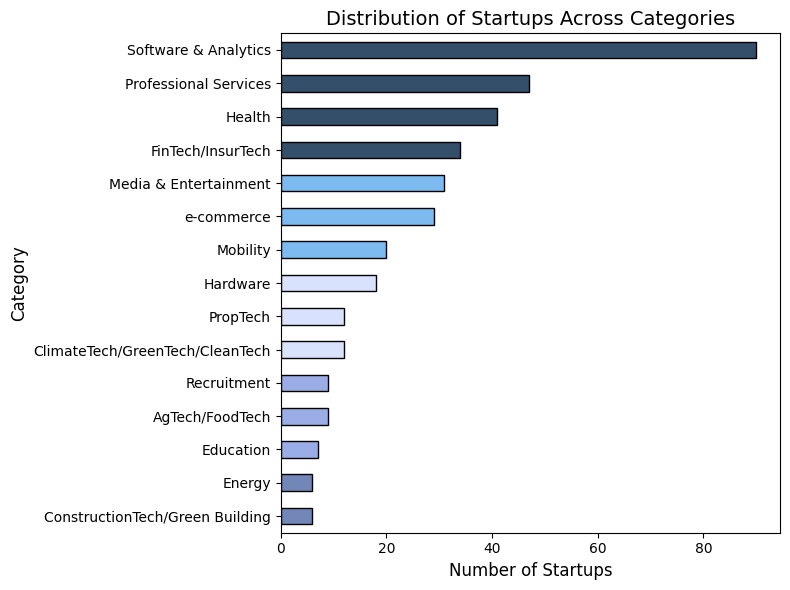

<Figure size 640x480 with 0 Axes>

In [67]:
# DIST OF STARTUPS ACROSS CATEGORIES

# count per category
counts = df['category'].value_counts().sort_values(ascending=True)

# choose a sequential colormap
cmap = cluster2 
colors = cmap(counts.rank(method='first') / counts.size)

# plot horizontal bar chart (more room for long names)
fig, ax = plt.subplots(figsize=(8,6))
counts.plot.barh(
    ax=ax,
    color=colors,
    edgecolor='black'
)

# styling
ax.set_title("Distribution of Startups Across Categories", fontsize=14)
ax.set_xlabel("Number of Startups", fontsize=12)
ax.set_ylabel("Category", fontsize=12)
plt.tight_layout()
plt.show()
plt.savefig("Distribution of Startups Across Categories.png")

In [53]:
# GROWTH RATES BY DEAL SECTORS

# adding data from EY industry reports on number of deals by sector
df_ey_deals_by_sec = pd.read_excel("data/Startups_AT_reports.xlsx", sheet_name="Deals by sector").loc[:, :'deals']
# rename the year column
df_ey_deals_by_sec['year'] = df_ey_deals_by_sec['year'].apply(lambda x: f"deals_by_sector_{x}")
# wide format: columns = year
df_ey_deals_by_sec = df_ey_deals_by_sec.pivot(index=['sector'], columns='year', values='deals').reset_index()
df_ey_deals_by_sec = df_ey_deals_by_sec.rename(columns={'sector':'category'})

df_categories = df.groupby(['region','category']).agg(num_startups = ('category', 'size')).reset_index()
df_categories = df_categories.merge(df.drop_duplicates('region').filter(regex=r'(employees_total_hours_worked_in_million|self-employees_total_hours_worked_in_million_|gross_fixed_capital_formation_current_prices_in_million_euro|compensation_of_employees_current_prices_in_million_euro|gross_value_added_at_basic_prices_current_prices_in_million_eur|population_|region$|startups_running_total|startups_with_financing)'), how='left', on='region').merge(df_ey_deals_by_sec, how='left', on='category')
df_categories = df_categories.sort_values(by=['region', 'num_startups'], ascending=False)

df_categories

,region,category,num_startups,startups_with_financing_2021,startups_with_financing_2022,startups_with_financing_2023,startups_with_financing_2024,population_2000,population_2001,population_2002,...,startups_running_total_2018,startups_running_total_2019,startups_running_total_2020,startups_running_total_2021,startups_running_total_2022,startups_running_total_2023,deals_by_sector_2021,deals_by_sector_2022,deals_by_sector_2023,deals_by_sector_2024
69,Vorarlberg,Hardware,2,2.0,1.0,2.0,2.0,349257.0,351356.0,353635.0,...,24,38,47,77,95,93,8.0,7.0,4.0,5.0
72,Vorarlberg,Software & Analytics,2,2.0,1.0,2.0,2.0,349257.0,351356.0,353635.0,...,24,38,47,77,95,93,5.0,33.0,58.0,53.0
68,Vorarlberg,ConstructionTech/Green Building,1,2.0,1.0,2.0,2.0,349257.0,351356.0,353635.0,...,24,38,47,77,95,93,NaN,NaN,NaN,NaN
70,Vorarlberg,Health,1,2.0,1.0,2.0,2.0,349257.0,351356.0,353635.0,...,24,38,47,77,95,93,4.0,14.0,18.0,19.0
71,Vorarlberg,Media & Entertainment,1,2.0,1.0,2.0,2.0,349257.0,351356.0,353635.0,...,24,38,47,77,95,93,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,Carinthia,Mobility,1,0.0,0.0,7.0,3.0,560129.0,559745.0,559179.0,...,92,112,122,120,145,134,8.0,11.0,12.0,6.0
6,Carinthia,Professional Services,1,0.0,0.0,7.0,3.0,560129.0,559745.0,559179.0,...,92,112,122,120,145,134,NaN,5.0,NaN,3.0
0,Burgenland,Media & Entertainment,1,NaN,NaN,NaN,NaN,276083.0,276331.0,276497.0,...,16,30,34,39,48,66,NaN,NaN,NaN,NaN
1,Burgenland,Professional Services,1,NaN,NaN,NaN,NaN,276083.0,276331.0,276497.0,...,16,30,34,39,48,66,NaN,5.0,NaN,3.0


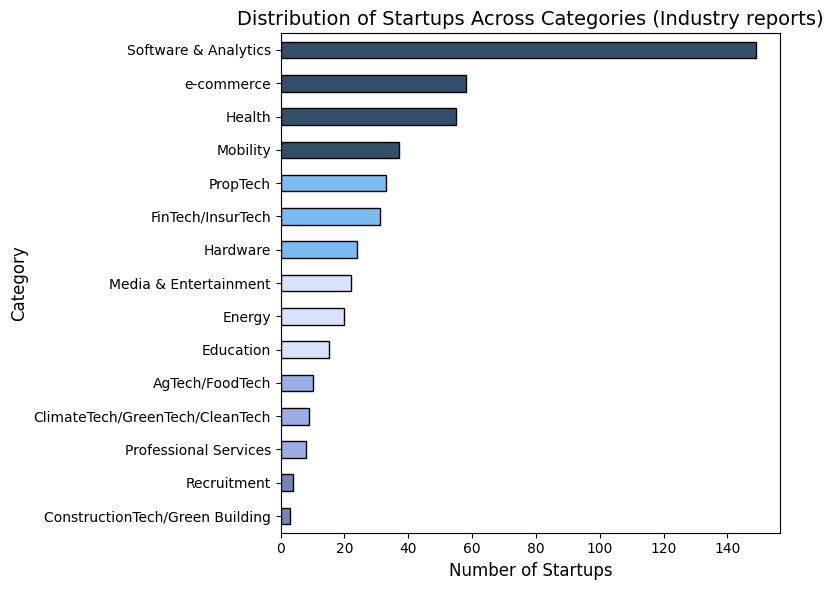

<Figure size 640x480 with 0 Axes>

In [66]:
# DIST OF STARTUPS ACROSS CATEGORIES (INDUSTRY REPORTS)

# reassembling data
df_deals_by_sec = df_ey_deals_by_sec[['category', 'deals_by_sector_2021', 'deals_by_sector_2022', 'deals_by_sector_2023', 'deals_by_sector_2024']].fillna(0)
df_deals_by_sec['deals_by_sector'] = df_deals_by_sec['deals_by_sector_2021']+df_deals_by_sec['deals_by_sector_2022']+df_deals_by_sec['deals_by_sector_2023']+df_deals_by_sec['deals_by_sector_2024']
df_deals_by_sec = df_deals_by_sec.sort_values(by='deals_by_sector', ascending=False)

# count per category
counts = df_deals_by_sec[['category', 'deals_by_sector']].set_index('category')['deals_by_sector'].sort_values(ascending=True)

# choose a sequential colormap
cmap = cluster2   
colors = cmap(counts.rank(method='first') / counts.size)

# plot horizontal bar chart (more room for long names)
fig, ax = plt.subplots(figsize=(8,6))
counts.plot.barh(
    ax=ax,
    color=colors,
    edgecolor='black'
)

# styling
ax.set_title("Distribution of Startups Across Categories (Industry reports)", fontsize=14)
ax.set_xlabel("Number of Startups", fontsize=12)
ax.set_ylabel("Category", fontsize=12)
plt.tight_layout()
plt.show()
plt.savefig("Distribution of Startups Across Categories (Industry reports).png")

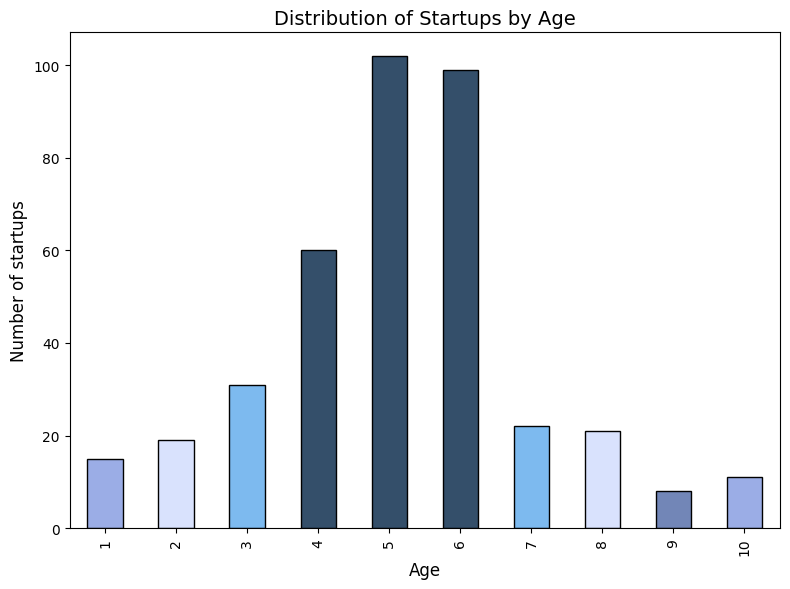

<Figure size 640x480 with 0 Axes>

In [65]:
# AGE OF STARTUPS DIST

# 1) count per category
counts = df['age'].value_counts().sort_index()

# 2) choose a sequential colormap
cmap = cluster2    # or 'OrRd', 'viridis', etc.
colors = cmap(counts.rank(method='first') / counts.size)

# 3) plot horizontal bar chart (more room for long names)
fig, ax = plt.subplots(figsize=(8,6))
counts.plot.bar(
    ax=ax,
    color=colors,
    edgecolor='black'
)

# 4) styling
ax.set_title("Distribution of Startups by Age", fontsize=14)
ax.set_xlabel("Age", fontsize=12)
ax.set_ylabel("Number of startups", fontsize=12)
plt.tight_layout()
plt.show()
plt.savefig("Distribution of Startups Across Age.png")

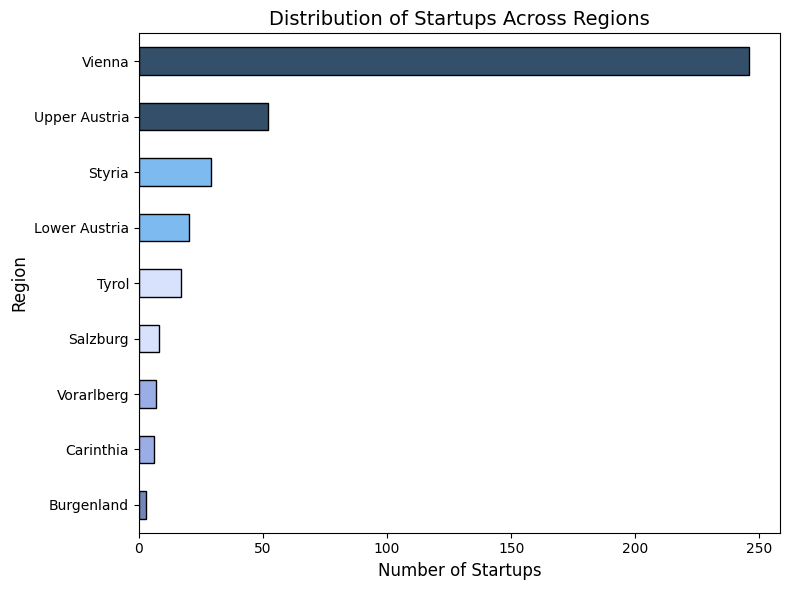

<Figure size 640x480 with 0 Axes>

In [68]:
# DIST OF STARTUPS ACROSS REGIONS

# 1) count per category
counts = df['region'].value_counts().sort_values(ascending=True)

# 2) choose a sequential colormap
cmap = cluster2 
colors = cmap(counts.rank(method='first') / counts.size)

# 3) plot horizontal bar chart (more room for long names)
fig, ax = plt.subplots(figsize=(8,6))
counts.plot.barh(
    ax=ax,
    color=colors,
    edgecolor='black'
)

# 4) styling
ax.set_title("Distribution of Startups Across Regions", fontsize=14)
ax.set_xlabel("Number of Startups", fontsize=12)
ax.set_ylabel("Region", fontsize=12)
plt.tight_layout()
plt.show()
plt.savefig("Distribution of Startups Across Regions.png")

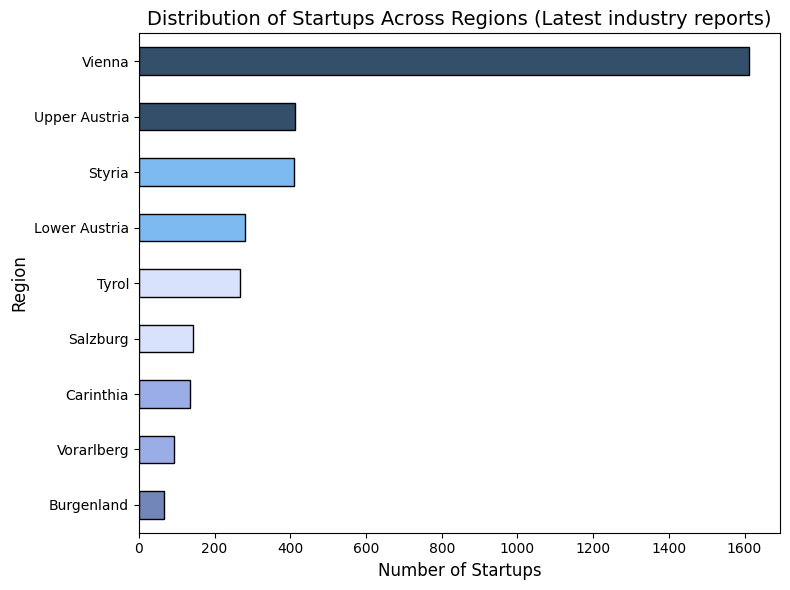

<Figure size 640x480 with 0 Axes>

In [69]:
# DIST OF STARTUPS ACROSS REGIONS (INDUSTRY REPORTS)

# adding data from EY industry reports on number of startups by region - running total
df_ey_startups_num_total = pd.read_excel("data/Startups_AT_reports.xlsx", sheet_name="ASM_number_of_startups")[['Year', 'Region', 'Total number of Startups']]
# remove the space + "(" + everything until the closing ")"
df_ey_startups_num_total['Year'] = df_ey_startups_num_total['Year'].apply(lambda x: f"startups_running_total_{x}")
# wide format: columns = Year
df_ey_startups_num_total = df_ey_startups_num_total[['Year', 'Region', 'Total number of Startups']].pivot(index=['Region'], columns='Year', values='Total number of Startups').reset_index()

df = df.merge(df_ey_startups_num_total, how='left', left_on='region', right_on='Region')

# 1) count per category
counts = df.drop_duplicates('region')[['region', 'startups_running_total_2023']].set_index('region')['startups_running_total_2023'].sort_values(ascending=True)

# 2) choose a sequential colormap
cmap = cluster2 
colors = cmap(counts.rank(method='first') / counts.size)

# 3) plot horizontal bar chart (more room for long names)
fig, ax = plt.subplots(figsize=(8,6))
counts.plot.barh(
    ax=ax,
    color=colors,
    edgecolor='black'
)

# 4) styling
ax.set_title("Distribution of Startups Across Regions (Latest industry reports)", fontsize=14)
ax.set_xlabel("Number of Startups", fontsize=12)
ax.set_ylabel("Region", fontsize=12)
plt.tight_layout()
plt.show()
plt.savefig("Distribution of Startups Across Regions.png")

### Pie charts

MovieWriter imagemagick unavailable; using Pillow instead.


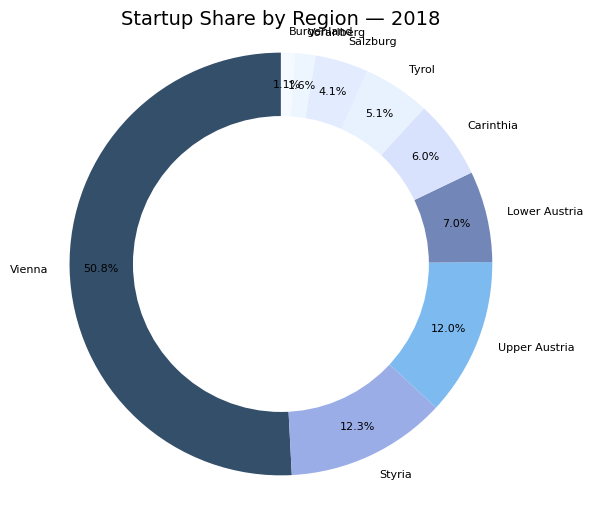

In [72]:
# 1) MELT into long
df_long = df_ey_startups_num_total.melt(
    id_vars="Region",
    var_name="Year",
    value_name="startups_running_total"
)
# extract year int from the column name
df_long["Year"] = df_long["Year"].str.extract(r"(\d{4})").astype(int)

cluster2_ext = ListedColormap([
    "#344F6A",  # darkest
    "#7286B7",
    "#7DBAEF",
    "#9BADE6",
    "#D9E2FD",  # original lightest
    "#E3ECFE",  # new
    "#E8F1FE",  # new
    "#EDF6FF",  # new
    "#F4FAFF",  # new (almost white)
], name="ColorCluster_2_ext")

region_colors = {
    "Vienna":        "#344F6A",
    "Lower Austria": "#7286B7",
    "Upper Austria": "#7DBAEF",
    "Styria":        "#9BADE6",
    "Carinthia":     "#D9E2FD",
    "Salzburg":      "#E3ECFE",
    "Tyrol":         "#E8F1FE",
    "Vorarlberg":    "#EDF6FF",
    "Burgenland":    "#F4FAFF",
}

years = sorted(df_long['Year'].unique())

fig, ax = plt.subplots(figsize=(6,6))

def update(i):
    ax.clear()
    year = years[i]
    
    # 2) Slice, compute shares, then sort descending
    data = (df_long[df_long['Year']==year]
            .groupby('Region')['startups_running_total']
            .sum())
    shares = (data / data.sum()).sort_values(ascending=False)

    # compute per-region shares and sort desc
    # extract labels and matching colors
    labels = shares.index.tolist()
    sizes  = shares.values
    colors = [region_colors[r] for r in labels]

    # draw the pie (donut) in that order, with fixed colors
    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=labels,
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,       
        pctdistance=0.85,
        textprops={'fontsize':8}
    )

    # draw center circle for donut
    centre = plt.Circle((0,0),0.70,fc='white')
    ax.add_artist(centre)

    ax.set_title(f"Startup Share by Region — {year}", fontsize=14)
    ax.axis('equal')  # keep it circular
    return wedges + texts + autotexts

anim = FuncAnimation(
    fig, update, 
    frames=len(years),
    interval=1000,    # ms between frames
    repeat=True
)

anim

anim.save("startups_running_total_over_time.gif", writer="imagemagick")

### Correlation

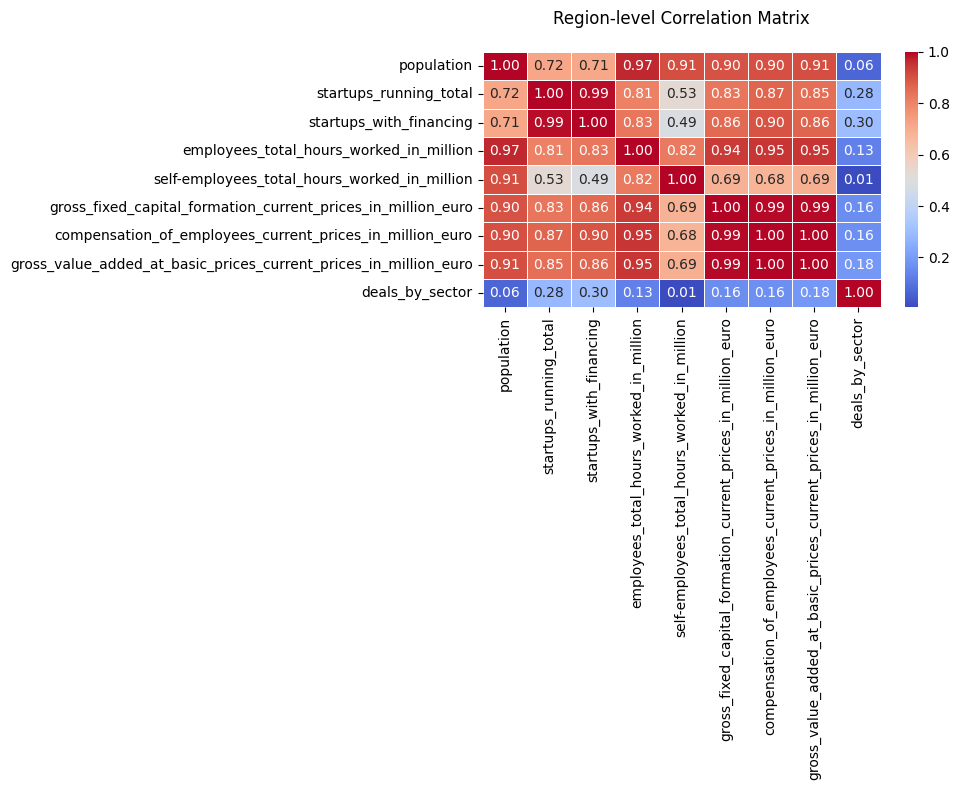

In [48]:
# use wide_to_long
df_long_all = pd.wide_to_long(df.drop_duplicates('region'),
    stubnames=['population','startups_running_total', 'startups_with_financing','employees_total_hours_worked_in_million',
               'self-employees_total_hours_worked_in_million','gross_fixed_capital_formation_current_prices_in_million_euro',
               'compensation_of_employees_current_prices_in_million_euro',
               'gross_value_added_at_basic_prices_current_prices_in_million_euro', 'deals_by_sector'],
    i=['region'], j='Year',
    sep='_', suffix=r'\d+'
).reset_index()

# 3) cast Year to int
df_long_all['Year'] = df_long_all['Year'].astype(int)

# 5) now corr
corr_matrix = df_long_all[[
    'population','startups_running_total', 'startups_with_financing','employees_total_hours_worked_in_million',
               'self-employees_total_hours_worked_in_million','gross_fixed_capital_formation_current_prices_in_million_euro',
               'compensation_of_employees_current_prices_in_million_euro',
               'gross_value_added_at_basic_prices_current_prices_in_million_euro', 'deals_by_sector'
]].corr()

#print(corr_matrix)

import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Region-level Correlation Matrix", pad=20)
plt.tight_layout()
plt.show()

In [73]:
df.columns[0:50]

Index(['name', 'link_startupeu', 'link_logo', 'link_website', 'website_up',
       'city', 'region', 'category_x', 'top_3_keywords', 'business_model',
       'linkedin_global_profile', 'linkedin_handle', 'linkedin_valid',
       'instagram_handle', 'instagram_valid', 'x_handle', 'x_valid',
       'founded_year', 'age', 'total_funding_listing', 'headline_count',
       'headlines', 'headline_financial_count', 'headline_funding',
       'headline_acquisition_count', 'headline_bankruptcy_count',
       'headline_non_financial_count', 'description_writing_score',
       'description_market_readiness_score',
       'description_founder_signal_score', 'description_word_count',
       'description_jargon_density', 'description_numeric_evidence_count',
       'status', 'category', 'startups_with_financing_2021',
       'startups_with_financing_2022', 'startups_with_financing_2023',
       'startups_with_financing_2024', 'deals_by_sector_2021',
       'deals_by_sector_2022', 'deals_by_sector_20

In [ ]:
# use wide_to_long
df_long_all = pd.wide_to_long(df.drop_duplicates('region'),
    stubnames=['population','startups_running_total', 'startups_with_financing','employees_total_hours_worked_in_million',
               'self-employees_total_hours_worked_in_million','gross_fixed_capital_formation_current_prices_in_million_euro',
               'compensation_of_employees_current_prices_in_million_euro',
               'gross_value_added_at_basic_prices_current_prices_in_million_euro', 'deals_by_sector'
               ],
    i=['region'], j='Year',
    sep='_', suffix=r'\d+'
).reset_index()

# 3) cast Year to int
df_long_all['Year'] = df_long_all['Year'].astype(int)

# 5) now corr
corr_matrix = df_long_all[[
    'population','startups_running_total', 'startups_with_financing','employees_total_hours_worked_in_million',
               'self-employees_total_hours_worked_in_million','gross_fixed_capital_formation_current_prices_in_million_euro',
               'compensation_of_employees_current_prices_in_million_euro',
               'gross_value_added_at_basic_prices_current_prices_in_million_euro', 'deals_by_sector','website_up','linkedin_valid','instagram_valid',
               'x_valid'
]].corr()

#print(corr_matrix)

import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Region-level Correlation Matrix", pad=20)
plt.tight_layout()
plt.show()

ValueError: stubname can't be identical to a column name

### Class graphs


Distribution of region by status (%)

status           funding   inactive  no_funding
region                                         
Burgenland      0.000000   0.000000    1.395349
Carinthia       0.900901   0.000000    2.325581
Lower Austria   9.009009   4.838710    3.255814
Salzburg        0.900901   1.612903    2.790698
Styria          7.207207   8.064516    7.441860
Tyrol           3.603604   1.612903    5.581395
Upper Austria  12.612613  11.290323   14.418605
Vienna         64.864865  70.967742   60.465116
Vorarlberg      0.900901   1.612903    2.325581 



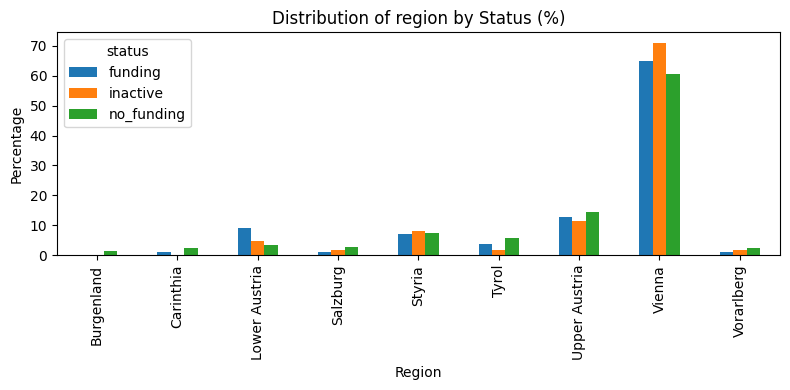


Distribution of category by status (%)

status                             funding   inactive  no_funding
category                                                         
AgTech/FoodTech                   4.629630   3.333333    0.985222
ClimateTech/GreenTech/CleanTech   4.629630   5.000000    1.970443
ConstructionTech/Green Building   1.851852   0.000000    1.970443
Education                         1.851852   3.333333    1.477833
Energy                            2.777778   1.666667    0.985222
FinTech/InsurTech                 9.259259  15.000000    7.389163
Hardware                          7.407407   1.666667    4.433498
Health                           15.740741   6.666667    9.852217
Media & Entertainment             5.555556   8.333333    9.852217
Mobility                          6.481481   5.000000    4.926108
Professional Services             6.481481  11.666667   16.256158
PropTech                          2.777778   3.333333    3.448276
Recruitment                       0

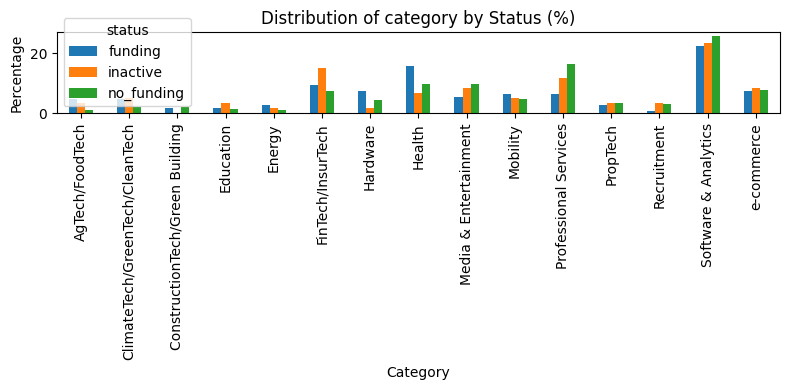


Distribution of business_model by status (%)

status            funding   inactive  no_funding
business_model                                  
B2B             72.972973  45.161290   63.255814
B2B2C            4.504505   4.838710    3.255814
B2C             18.918919  38.709677   25.581395
marketplace      0.000000   6.451613    2.790698
other            0.900901   1.612903    0.000000
platform         2.702703   3.225806    5.116279 



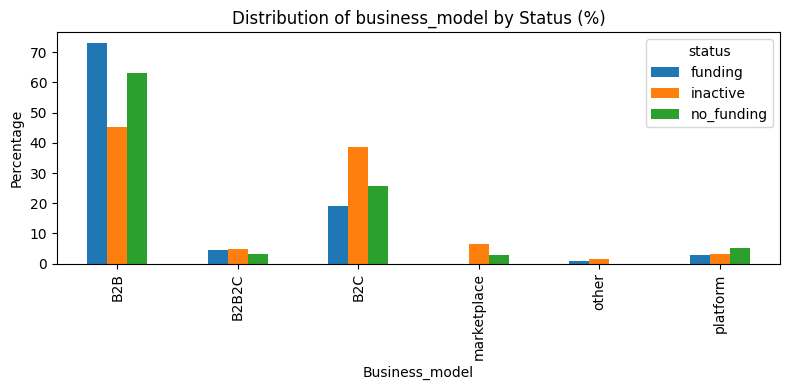


Mean of binary validity flags by status (%)

            linkedin_global_profile  linkedin_valid  instagram_valid    x_valid
status                                                                         
funding                    7.207207       89.189189        61.261261  48.648649
inactive                   0.000000       35.483871        50.000000  37.096774
no_funding                 2.790698       69.767442        61.860465  32.093023 



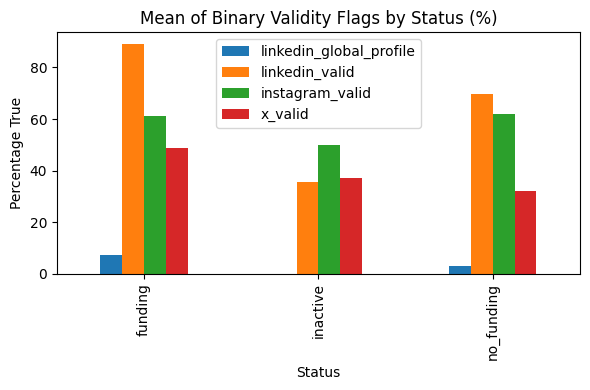

<Figure size 600x400 with 0 Axes>

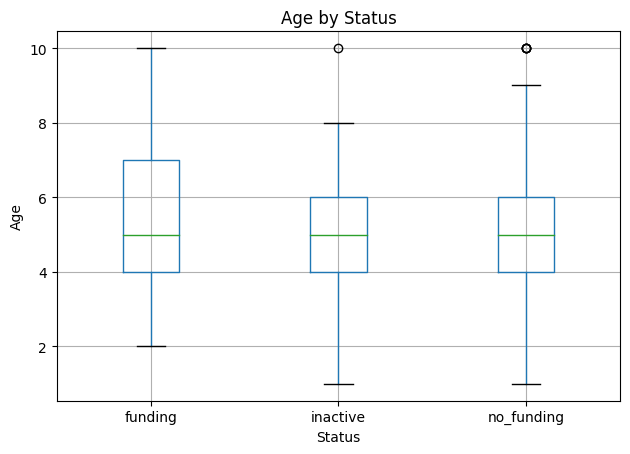

<Figure size 600x400 with 0 Axes>

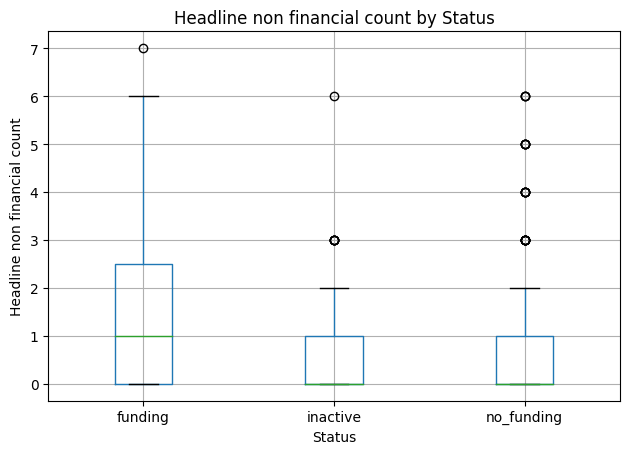


Mean of description_ variables by status

            description_writing_score  description_market_readiness_score  description_founder_signal_score  description_word_count  description_jargon_density  description_numeric_evidence_count
status                                                                                                                                                                                             
funding                      7.198198                            5.792793                          5.837838               84.585586                    0.231881                            0.342342
inactive                     7.064516                            5.596774                          5.548387               84.483871                    0.206560                            0.177419
no_funding                   7.088372                            5.804651                          5.637209              108.972093                    0.218769              

In [87]:
# Categorical variables analysis
categorical_vars = ['region', 'category', 'business_model']
for var in categorical_vars:
    ct = pd.crosstab(df[var], df['status'], normalize='columns') * 100

    # print the table
    print(f"\nDistribution of {var} by status (%)\n")
    print(ct.to_string(), "\n")

    # and plot it
    ct.plot(kind='bar', figsize=(8,4))
    plt.title(f"Distribution of {var} by Status (%)")
    plt.ylabel("Percentage")
    plt.xlabel(var.capitalize())
    plt.tight_layout()
    plt.show()


# Binary flags
binary_vars = ['linkedin_global_profile', 'linkedin_valid', 'instagram_valid', 'x_valid']
bin_summary = df.groupby('status')[binary_vars].mean() * 100

print("\nMean of binary validity flags by status (%)\n")
print(bin_summary.to_string(), "\n")

bin_summary.plot(kind='bar', figsize=(6,4))
plt.title("Mean of Binary Validity Flags by Status (%)")
plt.ylabel("Percentage True")
plt.xlabel("Status")
plt.tight_layout()
plt.show()


# Numerical variables
numerical_vars = ['age', 'headline_non_financial_count']
for var in numerical_vars:
    plt.figure(figsize=(6,4))
    df.boxplot(column=var, by='status')
    plt.title(f"{var.replace('_',' ').capitalize()} by Status")
    plt.suptitle("")  # remove automatic “Boxplot grouped by status” text
    plt.ylabel(var.replace('_',' ').capitalize())
    plt.xlabel("Status")
    plt.tight_layout()
    plt.show()


# Description variables
desc_vars = [col for col in df.columns if col.startswith('description_')]
desc_summary = df.groupby('status')[desc_vars].mean()

print("\nMean of description_ variables by status\n")
print(desc_summary.to_string(), "\n")

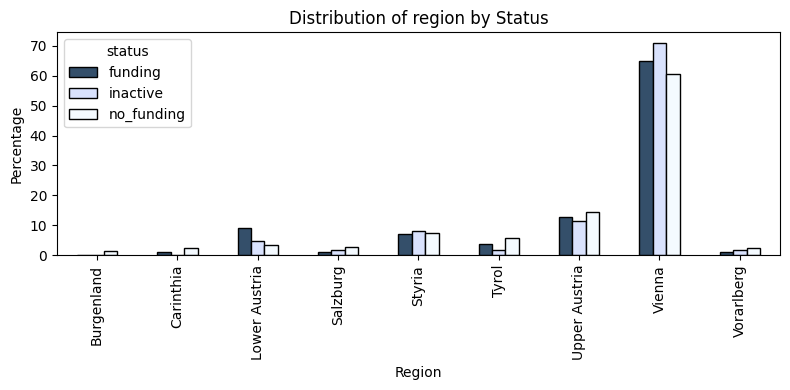

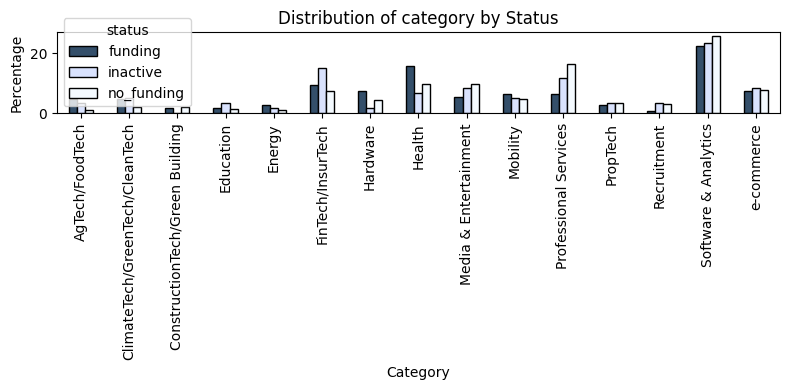

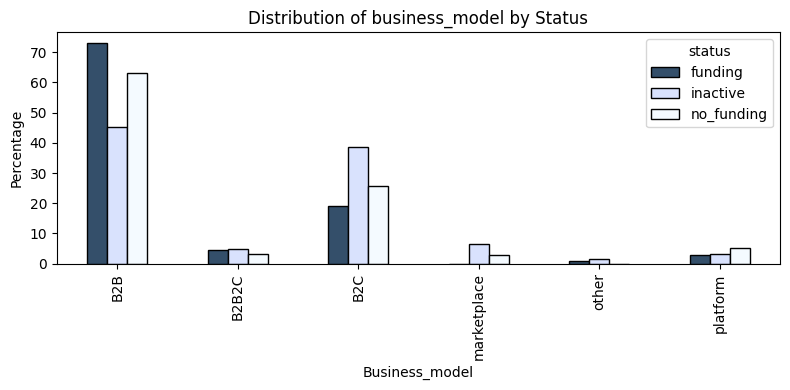

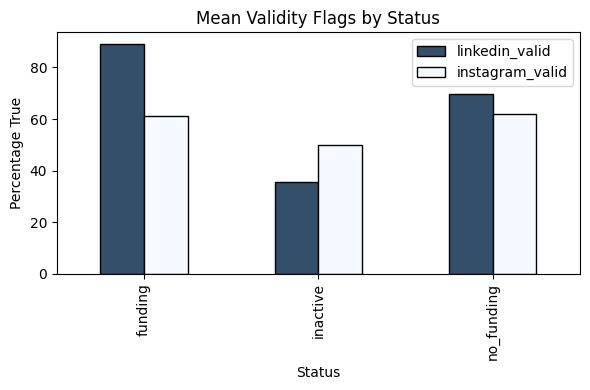

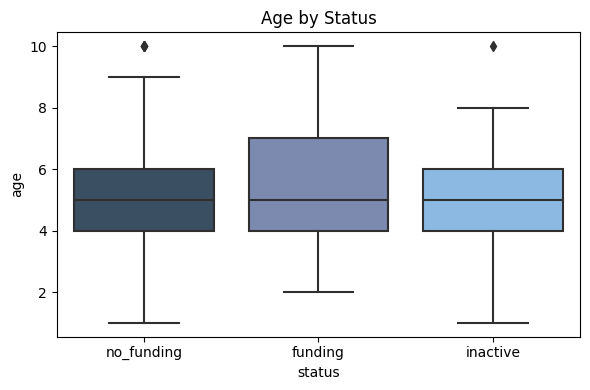

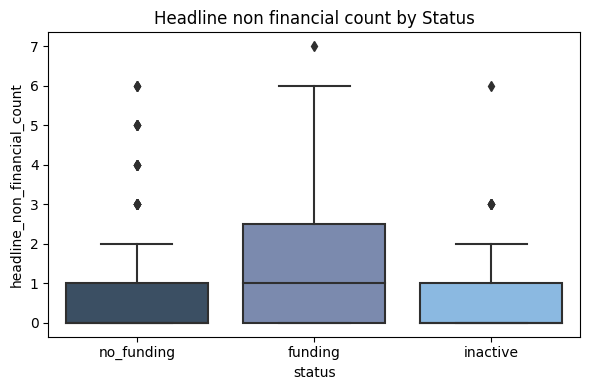

In [86]:
status_colors = cluster2_ext

# Categorical
for var in ['region','category','business_model']:
    ct = pd.crosstab(df[var], df['status'], normalize='columns')*100
    ct.plot.bar(
        colormap=status_colors, edgecolor='black', figsize=(8,4)
    )
    plt.title(f"Distribution of {var} by Status")
    plt.ylabel("Percentage")
    plt.xlabel(var.capitalize())
    plt.tight_layout()
    plt.show()

# Binary flags
bin_summary = df.groupby('status')[['linkedin_valid','instagram_valid']].mean()*100
bin_summary.plot.bar(
    colormap=status_colors, edgecolor='black', figsize=(6,4)
)
plt.title("Mean Validity Flags by Status")
plt.ylabel("Percentage True")
plt.xlabel("Status")
plt.tight_layout()
plt.show()

# Numerical
for var in ['age','headline_non_financial_count']:
    plt.figure(figsize=(6,4))
    sns.boxplot(
        x='status', y=var, data=df,
        palette=cluster2_ext.colors
    )
    plt.title(f"{var.replace('_',' ').capitalize()} by Status")
    plt.tight_layout()
    plt.show()

### Maps

MovieWriter imagemagick unavailable; using Pillow instead.


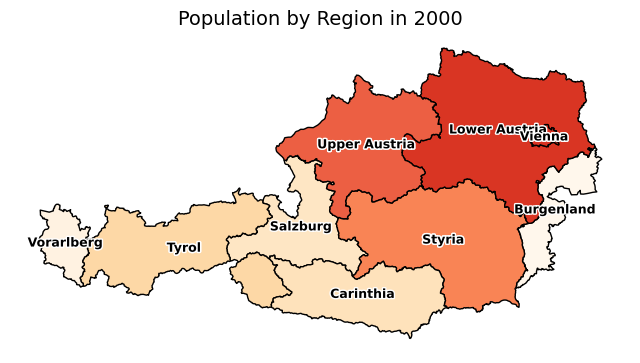

In [79]:
# the dataframe with geo info for mapping the regions
nuts2 = gpd.read_file("data/NUTS_RG_01M_2016_4326_LEVL_2.geojson")
nuts2 = nuts2.rename(columns={"NUTS_NAME":"Region"})

nuts2 = nuts2[nuts2["CNTR_CODE"]=="AT"]

eng2ger = {
    "Wien":"Vienna",
    "Niederösterreich":"Lower Austria",
    "Oberösterreich":"Upper Austria",
    "Steiermark":"Styria",
    "Kärnten":"Carinthia",
    "Tirol":"Tyrol",
    "Vorarlberg":"Vorarlberg",
    "Salzburg":"Salzburg",
    "Burgenland":"Burgenland"
}

# map regions to english names
nuts2["Region"] = nuts2["Region"].map(eng2ger)


# adding data from EY industry reports on number of startups with financing
df_ey_startups_num = pd.read_excel("data/Startups_AT_reports.xlsx", sheet_name="Startups with financing").loc[:, :'Number of startups that received financing']

# remove the space + "(" + everything until the closing ")"
df_ey_startups_num['Region'] = df_ey_startups_num['Region'].str.replace(r' \([^)]+\)', '', regex=True)
df_ey_startups_num['Year'] = df_ey_startups_num['Year'].apply(lambda x: f"startups_with_financing_{x}")

# wide format: columns = Year
df_ey_startups_num = df_ey_startups_num[['Year', 'Region', 'Number of startups that received financing']].pivot(index=['Region'], columns='Year', values='Number of startups that received financing').reset_index()

# add Burgenland even though empty
new_row = {
    'Region': 'Burgenland',
    'startups_with_financing_2021':  0,
    'startups_with_financing_2022':  0,
    'startups_with_financing_2023':  0,
    'startups_with_financing_2024':  0,
}
df_ey_startups_num = pd.concat([df_ey_startups_num, pd.DataFrame([new_row])], ignore_index=True)

# MELT
df_population = df.filter(regex=r'^(population_|region$)').drop_duplicates()

# 1) MELT into long
df_population = df_population.melt(
    id_vars="region",
    var_name="Year",
    value_name="population"
)
# extract year int from the column name
df_population["Year"] = df_population["Year"].str.extract(r"(\d{4})").astype(int)

df_population

years = sorted(df_population.Year.unique())

vmin = df_population.population.min()
vmax = df_population.population.max()
cmap = "OrRd"

fig, ax2 = plt.subplots(1,1, figsize=(8,6))

# 1) Create a single ScalarMappable and colorbar, BEFORE the animation
sm = mpl.cm.ScalarMappable(
    cmap=cmap,
    norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax)
)
sm._A = []  # dummy array for the colorbar
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label("Population")

def update(frame):
    ax2.clear()
    year = years[frame]

    # merge only Austria + this year
    year_df = df_population[df_population.Year == year]
    gdf = (
        nuts2[["Region","geometry"]]
        .merge(
            year_df.rename(columns={"region":"Region"}),
            left_on="Region",
            right_on="Region",
            how="inner"
        )
    )

    # 1) plot the choropleth
    gdf.plot(
        column="population",
        cmap=cmap,
        linewidth=1.0,
        edgecolor="black",
        vmin=vmin, vmax=vmax,
        legend=False,        # ← disable per‐frame legend
        ax=ax2
    )

    # 2) add your title & turn off axes
    ax2.set_title(f"Population by Region in {year}", fontsize=14)
    ax2.axis("off")

    # 3) annotate each region at its centroid
    #    you can precompute centroids on nuts2_at if you like,
    #    but computing here is fine for nine polygons
    for _, row in gdf.iterrows():
        x, y = row.geometry.centroid.xy
        ax2.text(
            x[0], y[0],
            row["Region"],            # or row["Region"] for German
            ha="center", va="center",
            fontsize=9, fontweight="bold",
            color="black",
            path_effects=[               # white halo
                path_effects.Stroke(linewidth=2, foreground="white"),
                path_effects.Normal()
            ]
        )

anim = FuncAnimation(fig, update, frames=len(years), interval=100)
anim

anim.save("population_over_time.gif", writer="imagemagick")

In [80]:
# 1) MELT into long
df_long = df_ey_startups_num.melt(
    id_vars="Region",
    var_name="Year",
    value_name="financed_startups"
)
# extract year int from the column name
df_long["Year"] = df_long["Year"].str.extract(r"(\d{4})").astype(int)

MovieWriter imagemagick unavailable; using Pillow instead.


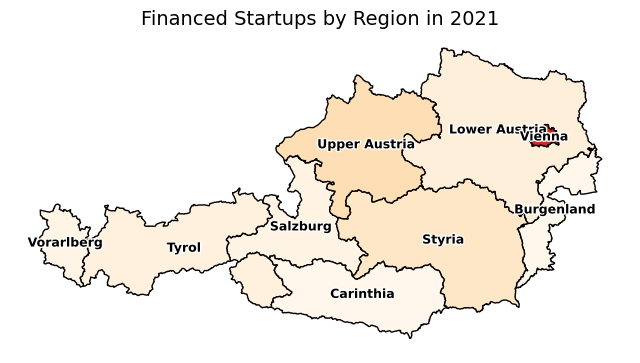

In [81]:
years = sorted(df_long.Year.unique())

vmin = df_long.financed_startups.min()
vmax = df_long.financed_startups.max()
cmap = "OrRd"

fig, ax2 = plt.subplots(1,1, figsize=(8,6))

# 1) Create a single ScalarMappable and colorbar, BEFORE the animation
sm = mpl.cm.ScalarMappable(
    cmap=cmap,
    norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax)
)
sm._A = []  # dummy array for the colorbar
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label("Number of Financed Startups")

def update(frame):
    ax2.clear()
    year = years[frame]

    # merge only Austria + this year
    year_df = df_long[df_long.Year == year]
    gdf = (
        nuts2[["Region","geometry"]]
        .merge(
            year_df.rename(columns={"Region":"Region"}),
            left_on="Region",
            right_on="Region",
            how="inner"
        )
    )

    # 1) plot the choropleth
    gdf.plot(
        column="financed_startups",
        cmap=cmap,
        linewidth=1.0,
        edgecolor="black",
        vmin=vmin, vmax=vmax,
        legend=False,        # ← disable per‐frame legend
        ax=ax2
    )

    # 2) add your title & turn off axes
    ax2.set_title(f"Financed Startups by Region in {year}", fontsize=14)
    ax2.axis("off")

    # 3) annotate each region at its centroid
    #    you can precompute centroids on nuts2_at if you like,
    #    but computing here is fine for nine polygons
    for _, row in gdf.iterrows():
        x, y = row.geometry.centroid.xy
        ax2.text(
            x[0], y[0],
            row["Region"],            # or row["Region"] for German
            ha="center", va="center",
            fontsize=9, fontweight="bold",
            color="black",
            path_effects=[               # white halo
                path_effects.Stroke(linewidth=2, foreground="white"),
                path_effects.Normal()
            ]
        )

anim = FuncAnimation(fig, update, frames=len(years), interval=1000)
anim

# plt.show()
anim.save("financed_startups_over_time.gif", writer="imagemagick")


Distribution of region by status (%)
 status         funding  inactive  no_funding
region                                      
Burgenland         0.0       0.0         1.4
Carinthia          0.9       0.0         2.3
Lower Austria      9.0       4.8         3.3
Salzburg           0.9       1.6         2.8
Styria             7.2       8.1         7.4
Tyrol              3.6       1.6         5.6
Upper Austria     12.6      11.3        14.4
Vienna            64.9      71.0        60.5
Vorarlberg         0.9       1.6         2.3


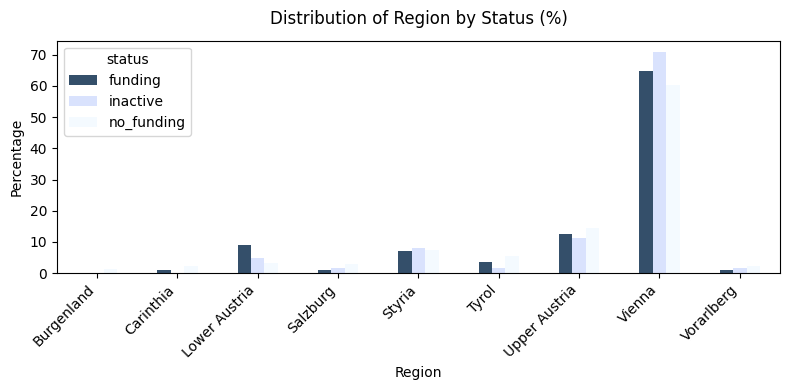


Distribution of category by status (%)
 status                           funding  inactive  no_funding
category                                                      
AgTech/FoodTech                      4.6       3.3         1.0
ClimateTech/GreenTech/CleanTech      4.6       5.0         2.0
ConstructionTech/Green Building      1.9       0.0         2.0
Education                            1.9       3.3         1.5
Energy                               2.8       1.7         1.0
FinTech/InsurTech                    9.3      15.0         7.4
Hardware                             7.4       1.7         4.4
Health                              15.7       6.7         9.9
Media & Entertainment                5.6       8.3         9.9
Mobility                             6.5       5.0         4.9
Professional Services                6.5      11.7        16.3
PropTech                             2.8       3.3         3.4
Recruitment                          0.9       3.3         3.0
Software & Ana

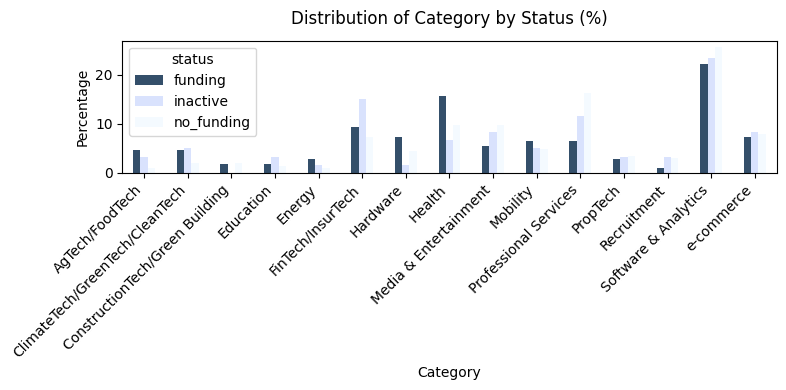


Distribution of business_model by status (%)
 status          funding  inactive  no_funding
business_model                               
B2B                73.0      45.2        63.3
B2B2C               4.5       4.8         3.3
B2C                18.9      38.7        25.6
marketplace         0.0       6.5         2.8
other               0.9       1.6         0.0
platform            2.7       3.2         5.1


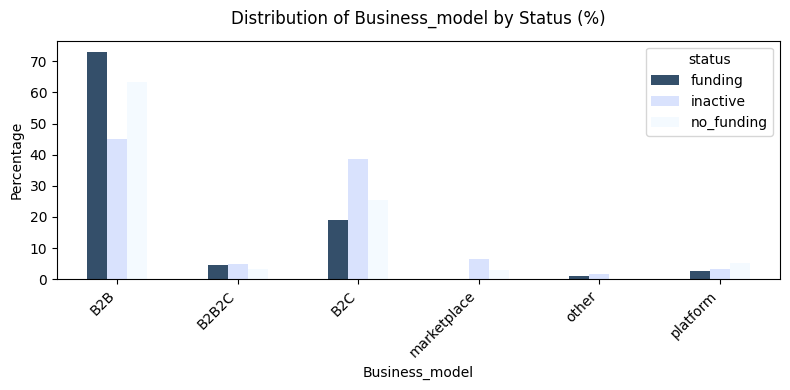


Mean of binary validity flags by status (%)
             linkedin_global_profile  linkedin_valid  instagram_valid  x_valid
status                                                                       
funding                         7.2            89.2             61.3     48.6
inactive                        0.0            35.5             50.0     37.1
no_funding                      2.8            69.8             61.9     32.1


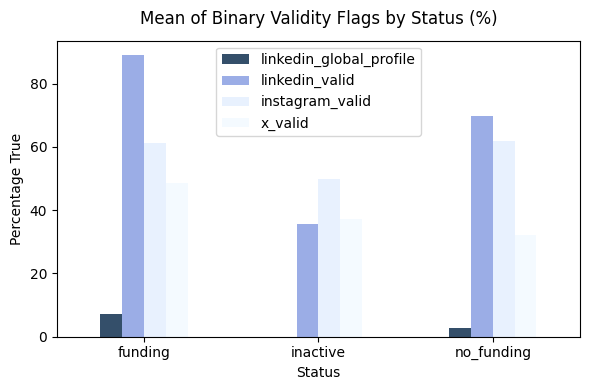

<Figure size 600x400 with 0 Axes>

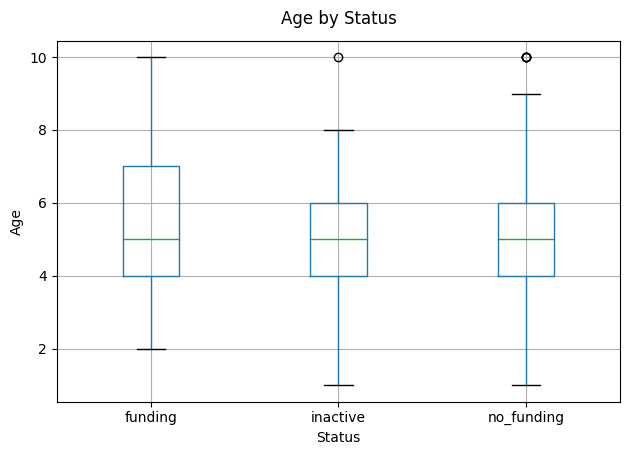

<Figure size 600x400 with 0 Axes>

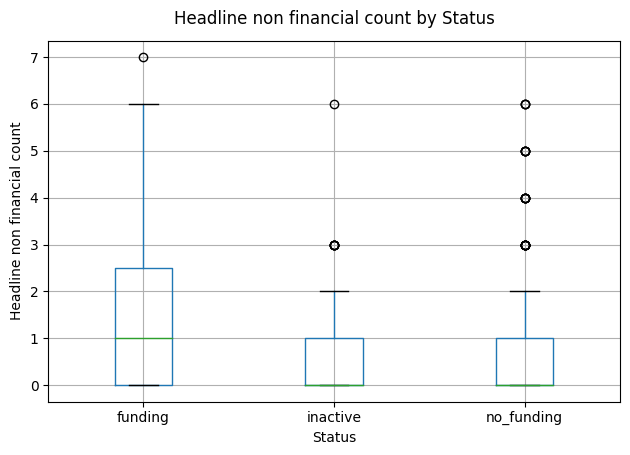


Mean of description_ variables by status
             description_writing_score  description_market_readiness_score  \
status                                                                      
funding                          7.20                                5.79   
inactive                         7.06                                5.60   
no_funding                       7.09                                5.80   

            description_founder_signal_score  description_word_count  \
status                                                                 
funding                                 5.84                   84.59   
inactive                                5.55                   84.48   
no_funding                              5.64                  108.97   

            description_jargon_density  description_numeric_evidence_count  
status                                                                      
funding                           0.23                  

In [89]:
status_colors = cluster2_ext

# 2) Categorical variables: percentage distribution by status
categorical_vars = ['region', 'category', 'business_model']
for var in categorical_vars:
    ct = pd.crosstab(df[var], df['status'], normalize='columns') * 100
    print(f"\nDistribution of {var} by status (%)\n", ct.round(1))
    # bar chart
    ax = ct.plot(kind='bar', figsize=(8,4), colormap=status_colors)
    ax.set_title(f'Distribution of {var.capitalize()} by Status (%)', pad=12)
    ax.set_ylabel('Percentage')
    ax.set_xlabel(var.capitalize())
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
# 3) Binary flags: mean true rate by status
binary_vars = ['linkedin_global_profile', 'linkedin_valid', 'instagram_valid', 'x_valid']
bin_summary = df.groupby('status')[binary_vars].mean() * 100
print("\nMean of binary validity flags by status (%)\n", bin_summary.round(1))
ax = bin_summary.plot(kind='bar', figsize=(6,4), colormap=status_colors)
ax.set_title('Mean of Binary Validity Flags by Status (%)', pad=12)
ax.set_ylabel('Percentage True')
ax.set_xlabel('Status')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
# 4) Numerical variables: boxplots by status
numerical_vars = ['age', 'headline_non_financial_count']
for var in numerical_vars:
    plt.figure(figsize=(6,4))
    df.boxplot(column=var, by='status')
    plt.title(f'{var.replace("_", " ").capitalize()} by Status', pad=12)
    plt.suptitle('')  # remove default suptitle
    plt.ylabel(var.replace('_', ' ').capitalize())
    plt.xlabel('Status')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
# 5) Description metrics: mean by status
desc_vars = [col for col in df.columns if col.startswith('description_')]
desc_summary = df.groupby('status')[desc_vars].mean()
print("\nMean of description_ variables by status\n", desc_summary.round(2))